# Deep learning with standard Python

Here, we will be traing a deep learning model with only Python. The only 3rd party libary I will be using is matplotlib to show images. It is obviously not meant to train a state of the art model or a production model. Instead, we will explore what it means to train a model using MNIST handwritten dataset. When I was reading a [blog post](https://sgugger.github.io/a-simple-neural-net-in-numpy.html#a-simple-neural-net-in-numpy) from Sylvain Gugger called, "A simple neural net in numpy," I found it interesting and wanted to try to write my version in standard Python. 

There are many libraries used for deep learning, such as Tensorflow and Keras, Pytorch, Scikit-Learn, numpy, and others. However, in order to understand basic concept of deep learning, we do no need to use any of these tools. 

Here are Python libraries I will be using. Other than matplotlib, all libraries are here:

In [ ]:
import gzip                             # Converting zip into python objects
import matplotlib.pyplot as plt         # Library for showing images
import random                           # Initializing random weights
import statistics                       # Getting mean or stdev
import math                             # Exponential function
import operator as op                   # just algebraic operators such as +, -, *, /
import time                             # Timing for performance
from functools import reduce

In [ ]:
import numpy as np

## Utilities

This section can be skipped as you can understand how deep learning works without understanding how these utilities work. You can consider these as built-in functions or machine language blobs. Simply fold the heading and run it.

If you decided to dig into lower level of deep learning, let's begin. Because we are only using python lists, we need to build utilities or tools we need in order to train our model. With other fancy libraries, these are built-in. However, because we are building up from scratch, we start with those basic utilities that we will use later on. How these are implemented specifically are not important at all for our purpose of understanding how deep learning works. As long as you get the general idea of what these functions do, that is good enough. However, please do not just run those cells without thinking about what they will return in advance if you want to understand more. Give yourself couple seconds to think and come up with output in your head. This will change your level of understanding.

With those low level functions, we will build up abstraction layers. First, I start with `shape`, which returns a tuple of shape of a matrix or a list.

In [ ]:
def shape(matrix) -> tuple:
    """ Get a shape of a matrix """
    def loop(mat, result):
        if not isinstance(mat, list):
            return result
        else:
            return loop(mat[0], result + (len(mat),))
    return loop(matrix, tuple())

In [ ]:
shape([1, 2])

(2,)

In [ ]:
shape([[1, 2, 3],
       [4, 5, 6]])

(2, 3)

In [ ]:
shape([[[1, 2],
        [3, 4]]])

(1, 2, 2)

It would be better if we can make matrices easier instead of making them by hand.

In [ ]:
def lst_nums(shape:tuple, num:int=1) -> list:
    """ Return a list of shape filled with num. 
        Default value for num is 1 """
    if isinstance(shape, tuple):
        x, y = shape
        return [[num]*y for _ in range(x)]
    else:
        x = shape
        return [num]*x

In [ ]:
lst_nums(1, 1)

[1]

In [ ]:
hund_1s = lst_nums((10, 10), 1)
len(hund_1s), len(hund_1s[0])

(10, 10)

In [ ]:
hund_1s

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

Here is a transpose function, which transposes a matrix. If you are not familiar with what it does, here is a [wikipedia](https://en.wikipedia.org/wiki/Transpose) page with an animation.

In [ ]:
def transpose (mat) -> list:
    "Transpose the matrix"
    return [[m[i] for m in mat] for i in range(len(mat[0]))]

In [ ]:
mat1 = [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]

In [ ]:
mat1

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

In [ ]:
transpose(mat1)

[[1, 4, 7], [2, 5, 8], [3, 6, 9]]

`map_mat` calls a fn (function) to a mat1 if there is only one matrix. If there are two matrices, it uses individual elements from both mat1 and mat2 as arguments for the fn. This is a long and complicated function, and I don't think I did a good job of writing it. It might be better to divide them by smaller functions, but I'm not sure. How would you improve it?

In [ ]:
def map_mat(fn, mat1, mat2=None) -> list:
    """ If there is only one matrix, call the function on the matrix.
        If map_mat is called with two matrices, call the function with 
        individual elements from mat1 and mat2 respectfully. 
        This function can handle broadcasting when mat2 is a vector. """
    if mat2 == None:
        return [list(map(fn, mat1[i])) for i in range(len(mat1))]
    mat = []
    try: 
        m1r,m1c = shape(mat1)
    except ValueError: 
        m1r = shape(mat1)[0]
        m1c = 0
    try: 
        m2r,m2c = shape(mat2)
    except ValueError: 
        m2r = shape(mat2)[0]
        m2c = 0
    if m1c == m2c == 0:                     # Two 1D vectors
        return list(map(fn, mat1, mat2))
    elif (m1r, m1c) == (m2r, m2c):          # two matrixs with same sizes
        return [[fn(x,y) for x,y in zip(mat1[i], mat2[i])] for i in range(len(mat1))]
    elif m1c == m2r and m2c==0:             # shape of (a, b), (b,)
        for i in range(m1r):
            mat.append([fn(x,y) for x,y in zip(mat1[i],mat2)])
        return mat
    elif m1r == m2r and m2c == 0:           # shape of (a, b), (a,)
        for i in range(m1r):
            mat.append([fn(m, mat2[i]) for m in mat1[i]])
        return mat
    else:
        raise Exception("map_mat error")

In [ ]:
hund_2s = lst_nums((10, 10), 2)

In [ ]:
hund_3s = map_mat(lambda x, y: x+y, hund_1s, hund_2s)
hund_3s

[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]

In [ ]:
map_mat(op.mul, hund_3s, hund_3s)

[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]

In [ ]:
map_mat(lambda x: x + 1, mat1)

[[2, 3, 4], [5, 6, 7], [8, 9, 10]]

Next, we have reshape function, which reshapes a matrix into new_shape.

In [ ]:
def reshape(matrix, new_shape) -> list:
    """ If matrix can be reshaped into new_shape, then
        return a new matrix with a respective shape. """
    old_shape = shape(matrix)
    elem_nums = mul(old_shape)
    if old_shape == new_shape:
        return matrix
    elif not elem_nums == mul(new_shape):
        raise Exception("Wrong shape!")
    else:
        return shaping(flatten(matrix), new_shape, elem_nums)

In [ ]:
def mul(lst: list) -> int:
    """ Return a result of all numbers multiplied.
        Like sum, but multiplying. """
    return reduce(op.mul, lst, 1)

In [ ]:
def shaping(flat, new_shape, elem_nums):
    """ Actually shaping flat array into new shape. """
    new_shape_len = len(new_shape)
    if new_shape_len == 1 or new_shape_len == 0:
        return result
    div = elem_nums // new_shape[0] # div = 50
    result = [flat[(i * div):((i+1) * div)] for i in range(new_shape[0])]
    if new_shape_len == 2:
        return result
    else:
        return [shaping(result[i], new_shape[1:], div) for i in range(new_shape[0])]

In [ ]:
def flatten(matrix):
    """ Flatten a matrix into a 1 dimensional list. """
    result = []
    for i in range(len(matrix)):
        if isinstance(matrix[i], list):
            result.extend(flatten(matrix[i]))
        else:
            result.append(matrix[i])
    return result

Testing new tools 

In [ ]:
# Reshape works with shape function.
shape(reshape(hund_1s, (100, 1))), shape(reshape(hund_1s, (1, 100)))

((100, 1), (1, 100))

In [ ]:
shape(reshape(hund_1s, (2, 5, 10)))

(2, 5, 10)

In [ ]:
mat3 = [[[1, 2],
         [3, 4]],
        [[5, 6],
         [7, 8]]]
mat3, shape(mat3)

([[[1, 2], [3, 4]], [[5, 6], [7, 8]]], (2, 2, 2))

In [ ]:
shape(reshape(mat3, (4, 2))), reshape(mat3, (4, 2))

((4, 2), [[1, 2], [3, 4], [5, 6], [7, 8]])

## Collecting Data

With those utilities, we can get started on getting our hands dirty with deep learning.

First, we need data if we want to do some training. We are using [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains handwritten digits, from Yann Lecun website. The dataset has 60,000 training images and 10,000 testing images. When we look at amazing things computers were trained to do, such as self driving cars and speech recognition, there were actually a lot of data fed into them for training. Although we tend to only give credits to those who came up with state of the art models, nothing could have been possible without those who prepared for data. 

In [ ]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2021-09-03 01:35:44--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  37.6MB/s    in 0.3s    

2021-09-03 01:35:44 (37.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2021-09-03 01:35:44--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[=========

In [ ]:
!ls

sample_data		   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz


Now, I am making a directory for all the data and putting data inside.

In [ ]:
# Todo: Change the code into using python pathlib library 
!mkdir data
!mv train-images-idx3-ubyte.gz data/
!mv train-labels-idx1-ubyte.gz data/
!mv t10k-images-idx3-ubyte.gz data/
!mv t10k-labels-idx1-ubyte.gz data/
!ls data/

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


Now, we have files we need. With `py_mnist_images` and `py_mnist_labels`, we convert these files into lists of images. I got those functions from [here](https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python), which originally returned numpy arrays, but I changed them to return lists. After calling those functions, we call `reshape` function to make them shapes of images, which are 28 by 28 pixels.

In [ ]:
def py_mnist_images(fname:str, pct:1) -> list:
    """ Convert zip files into lists of images. 
        Only returning pct percent of data.     """
    with gzip.open('data/'+fname, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # image_count = int(image_count * percent)
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = reshape(list(image_data), (image_count, column_count, row_count))
        return images[:int(image_count * pct)]
        # return reshape(images, (image_count, column_count, row_count))

def py_mnist_labels(fname:str, pct:1) -> list:
    """ Convert zip files into lists of labels. 
        Only returning pct percent of data.     """
    with gzip.open('data/'+fname, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = list(label_data)
        return labels[:int(label_count * pct)]

With `py_mnist_images`, we get lists of images. We call these matrices. When an array has 1 dimension, it is a vector, and an array 2 or more dimensions is called matrix. 

Let's us only 1% of the data because python is slow. 

In [ ]:
train_imgs = py_mnist_images('train-images-idx3-ubyte.gz', pct=0.01)
train_labels = py_mnist_labels('train-labels-idx1-ubyte.gz', pct=0.01)
test_imgs = py_mnist_images('t10k-images-idx3-ubyte.gz', pct=0.01)
test_labels = py_mnist_labels('t10k-labels-idx1-ubyte.gz', pct=0.01)

Let's take a look at those data before we move on. We want to make sure we are working with correct data. Using `plt.imshow`, we can take a look at each image.

In [ ]:
type(train_imgs), type(train_imgs[0][0][0])

(list, int)

In [ ]:
shape(train_imgs), shape(train_labels), shape(test_imgs), shape(test_labels)

((600, 28, 28), (600,), (100, 28, 28), (100,))

Here are pictures with labels. 

5

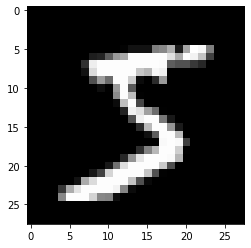

In [ ]:
plt.imshow(train_imgs[0], cmap='gray'); train_labels[0]

0

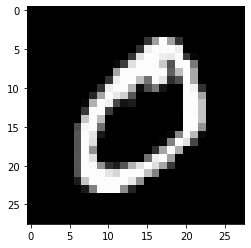

In [ ]:
plt.imshow(train_imgs[1], cmap='gray'); train_labels[1]

4

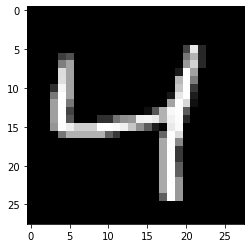

In [ ]:
plt.imshow(train_imgs[2], cmap='gray'); train_labels[2]

Now that we have some tools to work with, we can prepare our data for training. First, we will reshape our data. We are combining x and y axis into a vector (1-dimensional array) so that one array equals to one image. Then, we normalize our data by dividing them by 255 because the highest value is 255. 

In [ ]:
train_imgs = reshape(train_imgs, (600, 28 * 28))
test_imgs = reshape(test_imgs, (100, 28 * 28))
shape(train_imgs), shape(test_imgs)

((600, 784), (100, 784))

In [ ]:
train_imgs = map_mat(lambda x: x / 255, train_imgs)
test_imgs = map_mat(lambda x: x / 255, test_imgs)

In [ ]:
train_imgs[0][400:450]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3176470588235294,
 0.9411764705882353,
 0.9921568627450981,
 0.9921568627450981,
 0.4666666666666667,
 0.09803921568627451,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.17647058823529413,
 0.7294117647058823,
 0.9921568627450981,
 0.9921568627450981,
 0.5882352941176471,
 0.10588235294117647,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

## Initializing Weights

data + weight & bias = model

Another ingredient for deep learning is a set of weights.

In [ ]:
def lst_random(shape, init_parms=False):
    "return a list of randoms and if init_parms is True, initialize parameters using Kaiming init."
    x, y = shape
    res = lst_nums(shape, 0)
    for i in range(x):
        for j in range(y):
            res[i][j] = random.normalvariate(0,1)
            if init_parms: res[i][j] *= math.sqrt(2/x)
    return res

In [ ]:
rand_mat = lst_random((10,10))
shape(rand_mat)

(10, 10)

Using Kaiming init. With Kaiming init, we get a head start compared to using just random numbers.

In [ ]:
sample = lst_random((200, 100), True)
# x = map_mat(lambda x: x*0.1, x)
# statistics.stdev(x[0])

Checking whether the initialization works. Standard deviation should equal to sqrt(2/n_in), and mean should be 0. And this works. With this initialization, we can train deeper layers. For more information, paper is [here](https://arxiv.org/abs/1502.01852).

In [ ]:
def check_dist(x):
    for i in range(len(x)//10):
        print(statistics.stdev(x[i]), statistics.mean(x[i]))

In [ ]:
math.sqrt(2/200)

0.1

In [ ]:
check_dist(sample)

0.09297750982483842 -0.005551492975462343
0.09377392014470953 -0.0004644530715541377
0.0880266808855306 0.0014302874910074933
0.10476777083224814 0.006420732596219193
0.11401894394433278 0.0026472387089674365
0.09504169857687136 -0.016832640036345214
0.10115404723103125 0.008298330317628617
0.10003722020964131 -0.001963013655344632
0.10840916095212666 -0.003917221072107054
0.09475181552257386 0.010960612697832342
0.10749452903124168 -0.00043170903663133643
0.11426827714443664 -0.01592956027184722
0.09805584337087062 0.006115694202963703
0.09530437918322529 0.0010778647613035926
0.10786920778882839 -4.886472580181381e-05
0.09951682764549248 0.004193264024171723
0.10069742267004245 -0.0041036793564703114
0.12237299727220302 -0.008247944715812132
0.10771116381117542 0.010819112201489189
0.09027209249627051 -0.010052280483938152


In [ ]:
# %timeit -n 20 for_sum(sum_test)

## Matrix multiplication

Now that our data is ready, it is time to look at matrix multiplication, which is the most frequently used operation in deep learning.

In [ ]:
x = lst_random((200,100))

In [ ]:
x[1][:5]

[0.9347526378113412,
 -0.1316092325249455,
 -1.7432261605942205,
 -0.5668829848642469,
 -0.22568080371154053]

If shape is (2,3):
[[1,1,1],
 [1,1,1]]
 Also, if matrix multiplication between (2, 3) and (3, 4) should be (2, 4)

In [ ]:
def py_matmul1(a,b):
    "Needs some speed ups"
    ar,ac = len(a),len(a[0])
    br,bc = len(b),len(b[0])
    assert ac == br, f'Size of ar ({ac}) does not match br ({br}).'
    c = lst_nums((ar, bc), 0)
    for i in range(ar):
         for j in range(bc):
             for z in range(ac):
                 c[i][j] += a[i][z] * b[z][j]
    return c

In [ ]:
m1 = [[1,2],[3,4]]
m2 = [[0,3],[2,5]]
m5 = [[1,2,3,4],[5,6]]

In [ ]:
py_matmul1(m1,m2)

[[10, 13], [22, 29]]

In [ ]:
ml1 = lst_random((784, 100))
ml2 = lst_random((100, 10))

It works, but it is slow. We can make it faster by getting rid of for loop.

In [ ]:
# %timeit -n 20 py_matmul(ml1, ml2)

In [ ]:
def col_mat (mat:list, col:int) -> list:
    "Get a column of a matrix."
    return [m[col] for m in mat]

In [ ]:
def py_matmul2(a,b):
    "Use sum function"
    ar,ac = len(a),len(a[0])
    br,bc = len(b),len(b[0])
    assert ac == br, f'Size of ar ({ac}) does not match br ({br}).'
    c = lst_nums((ar, bc), 0)
    for i in range(ar):
         for j in range(bc):
             c[i][j] = sum(map_mat(op.mul, a[i], col_mat(b,j)))
    return c

Using two for loops is faster than using three. 

In [ ]:
# %timeit -n 20 py_matmul2(ml1, ml2)

In [ ]:
def py_matmul3(a, b):
    ar,ac = len(a),len(a[0])
    br,bc = len(b),len(b[0])
    assert ac == br, f'Size of ar ({ac}) does not match br ({br}).'
    c = lst_nums((ar, bc), 0)
    for i in range(ar):
        c[i] = [sum(map_mat(op.mul, a[i], col_mat(b,j))) for j in range(bc)]
    return c

In [ ]:
# py_matmul3(m1, m2)

In [ ]:
# %timeit -n 20 py_matmul3(ml1, ml2)

In [ ]:
# %prun py_matmul3(ml1, ml2)

Even with reducing it to one loop, we did not really gain much speed. After using prun, we can see that elementwise is using a lot of time. We can probably get away without using elemtwise to achieve matrix multiplication.

In [ ]:
def py_matmul4(a, b):
    ar,ac = len(a),len(a[0])
    br,bc = len(b),len(b[0])
    assert ac == br, f'Size of ar ({ac}) does not match br ({br}).'
    c = lst_nums((ar, bc), 0)
    t = transpose(b)
    for i in range(ar):
        c[i] = [sum(map(lambda x: x[0] * x[1], zip(a[i], (t[j])))) for j in range(bc)]
    return c

In [ ]:
# py_matmul4(m1, m2)

Without elementwise, we gained some speed compared to other versions. 

In [ ]:
# %timeit -n 20 py_matmul4(ml1, ml2)

In [ ]:
# %prun py_matmul4(ml1, ml2)

I am still not satisfied with the result yet. I am sure we can do better. Let's get some help from itertools.

Default sum takes the longest time to execute now, but it is faster option we have, compared to using for loop or reduce function.

In [ ]:
def py_matmul(a, b):
    ar,ac = len(a),len(a[0])
    br,bc = len(b),len(b[0])
    assert ac == br, f'Size of ar ({ac}) does not match br ({br}).'
    c = lst_nums((ar, bc), 0)
    t = transpose(b)
    for i in range(ar):
        c[i] = [sum(map(op.mul, a[i], t[j])) for j in range(bc)]
    return c

In [ ]:
py_matmul(m1, m2)

[[10, 13], [22, 29]]

## Model

First, we will make a model with classes first. 

In [ ]:
m1_np = np.array(m1)
m2_np = np.array(m2)

In [ ]:
class Relu():
    def forward(self, x):
        self.old_x = x.copy()
        res = map_mat(lambda y: 0 if y < 0 else y, x)
        return res

    def backward(self, grad):
        res = map_mat(lambda x, g: g if x > 0 else 0, self.old_x, grad)
        return res

In [ ]:
class Relu_np():
    def forward(self, x):
        self.old_x = np.copy(x)
        return np.clip(x,0,None)

    def backward(self, grad):
        return np.where(self.old_x>0,grad,0)

In [ ]:
relu = Relu()
relu_np = Relu_np()
relu.forward(m1), relu_np.forward(m1)

([[1, 2], [3, 4]], array([[1, 2],
        [3, 4]]))

In [ ]:
relu.backward(m2), relu_np.backward(m2_np)

([[2, 3], [4, 5]], array([[2, 3],
        [4, 5]]))

In [ ]:
class Softmax():
    def forward(self, inp):
        mat = map_mat(math.exp, inp)
        self.old_y = []
        for i in range(len(mat)):
            s = sum(mat[i])
            self.old_y.append([x/s for x in mat[i]])
        return self.old_y
    
    def backward(self, grad):
        res = map_mat(op.mul, self.old_y, grad)
        res = [sum(res[i]) for i in range(len(self.old_y))] # shape is (64,)
        # res = reshape(res, (2, 1))
        # print(f'Softmax: {res}')
        # res = map_mat(op.sub, grad, res)
        res = [list(map(lambda x: x - res[i], grad[i])) for i in range(len(grad))]
        # print(f'Softmax: {res}')
        return map_mat(op.mul, self.old_y, res)

In [ ]:
class Softmax_np():
    def forward(self,x):
        self.old_y = np.exp(x) / np.exp(x).sum(axis=1) [:,None]
        return self.old_y

    def backward(self,grad):
        res = (grad * self.old_y).sum(axis=1)[:,None]
        print(f'Softmax_np: {res}')
        res = grad - res
        print(f'Softmax_np: {res}')
        # return self.old_y * (grad - (grad * self.old_y).sum(axis=1)[:,None])
        return self.old_y * res

In [ ]:
m1_np.sum(axis=1)[:,None]

array([[3],
       [7]])

In [ ]:
sm = Softmax()
sm_np = Softmax_np()
sm.forward(m1), sm_np.forward(m1)

([[0.2689414213699951, 0.7310585786300049],
  [0.2689414213699951, 0.7310585786300048]],
 array([[0.26894142, 0.73105858],
        [0.26894142, 0.73105858]]))

In [ ]:
m2_np

array([[0, 3],
       [2, 5]])

In [ ]:
m2_np - [[2], [1]]

array([[-2,  1],
       [ 1,  4]])

In [ ]:
m2_np - [[2.19317574],[4.19317574]]

array([[-2.19317574,  0.80682426],
       [-2.19317574,  0.80682426]])

In [ ]:
sm.backward(m2), sm_np.backward(m2_np)

Softmax: [2.193175735890015, 4.193175735890014]
Softmax: [[-2.193175735890015, 0.8068242641099852], [-2.193175735890014, 0.8068242641099861]]
Softmax_np: [[2.19317574]
 [4.19317574]]
Softmax_np: [[-2.19317574  0.80682426]
 [-2.19317574  0.80682426]]


([[-0.5898357997244456, 0.5898357997244454],
  [-0.5898357997244453, 0.589835799724446]],
 array([[-0.5898358,  0.5898358],
        [-0.5898358,  0.5898358]]))

In [ ]:
def softmax_b(old_y, grad):
    # shape of old_y is (64, 10), and grad is (64,)
    res = map_mat(op.mul, old_y, grad)
    res = [sum(res[i]) for i in range(len(old_y))] # shape is (64,)
    return map_mat(op.mul, old_y, map_mat(op.sub, grad, res))

In [ ]:
softmax_b([[0.2689414213699951, 0.7310585786300049],[0.2689414213699951, 0.7310585786300048]], m2)

[[-0.19661193324148193, -1.2655052240185276],
 [0.34127090949850825, 0.1966119332414822]]

In [ ]:
class CrossEntropy():
    def forward(self, inp, targ):
        mat = map_mat(lambda x: x if x>1e-8 else 1e-8, inp)
        self.old_x = mat.copy()
        self.old_y = targ
        res = []
        for i in range(len(mat)):
            for j in range(len(targ[0])):
                if targ[i][j] == 1:
                    res.append(-math.log(mat[i][j]))
        return res

    def backward(self):
        mat = map_mat(lambda x: x if x>1e-8 else 1e-8, self.old_x)
        # mat = self.old_x
        res = lst_nums(shape(self.old_x), num=0.)
        for i in range(len(mat)):
            for j in range(len(self.old_y[0])):
                if self.old_y[i][j] == 1:
                    res[i][j] = (-1/(mat[i][j]))
        return res

In [ ]:
class CrossEntropy_np():
    def forward(self,x,y):
        self.old_x = x.clip(min=1e-8,max=None)
        self.old_y = y
        return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

    def backward(self):
        return np.where(self.old_y==1,-1/self.old_x, 0)

In [ ]:
ce = CrossEntropy()
ce_np = CrossEntropy_np()
ce.forward(m1, [[0, 1], [1, 0]]), ce_np.forward(m1_np, np.array([[0, 1], [1, 0]]))

([-0.6931471805599453, -1.0986122886681098], array([-0.69314718, -1.09861229]))

In [ ]:
ce.backward(), ce_np.backward()

([[0.0, -0.5], [-0.3333333333333333, 0.0]], array([[ 0.        , -0.5       ],
        [-0.33333333,  0.        ]]))

In [ ]:
class Linear():
    def __init__(self, n_in, n_out):
        self.weights = lst_random((n_in, n_out), True) 
        # self.weights = [[1, 2], [3, 4]]
        self.biases = lst_nums((n_out), num=0)
    
    def forward(self, inp):
        self.old_x = inp
        return map_mat(lambda x, y: x + y, py_matmul(inp, self.weights), self.biases)
    
    def backward(self, grad):
        self.grad_b = mean_0(grad)
        self.grad_w = py_matmul(transpose(self.old_x), grad)
        out = py_matmul(grad, transpose(self.weights))
        return out

In [ ]:
class Linear_np():
    def __init__(self,n_in,n_out):
        self.weights = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
        # self.weights = np.array([[1, 2], [3, 4]])
        self.biases = np.zeros(n_out)

    def forward(self, x):
        self.old_x = x
        return np.dot(x,self.weights) + self.biases

    def backward(self,grad):
        self.grad_b = grad.mean(axis=0)
        self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
        return np.dot(grad,self.weights.transpose())

In [ ]:
l = Linear(2,2)
l_np = Linear_np(2,2)
l.forward(m1), l_np.forward(m1_np)

([[7, 10], [15, 22]], array([[ 7., 10.],
        [15., 22.]]))

In [ ]:
l.backward(m2), l_np.backward(m2_np)

([[8, 18], [14, 32]], array([[ 8, 18],
        [14, 32]]))

In [ ]:
def mean_0 (matrix):
    "Find a mean in matrix over 0 axis"
    return [statistics.mean([m[i] for m in matrix]) for i in range(len(matrix[0]))]

In [ ]:
class Model():
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def make_preds(self, x):
        outputs = self.forward(x)   # (64, 10)
        preds = [outputs[i].index(max(outputs[i])) for i in range(len(outputs))]
        return preds

    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            # print(f'grad for one before {self.layers[i]} is {shape(grad)}')
            grad = self.layers[i].backward(grad)
        # print(f'first gradient is {grad[0]}')

In [ ]:
class Model_np():
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)

In [ ]:
def load_minibatches(trn, targets, bs=64):
    data = []
    for i in range((len(trn) // bs) - 1):
        targs = lst_nums((bs, 10), 0)
        targets_mb = targets[(i*bs) : ((i+1)*bs)]
        for z in range(bs):
            targs[z][targets_mb[z]] = 1.
        data.append((trn[:bs],targs))
    return data

In [ ]:
dataset = load_minibatches(train_imgs, train_labels)
shape(dataset)

(8,)

In [ ]:
def train(model, lr ,nb_epoch, data, testset):
    for epoch in range(nb_epoch):
        running_loss = 0.
        num_inputs = 0
        for mini_batch in data:
            corrects = 0
            inputs, targets = mini_batch
            test_inp, test_targs = testset
            num_inputs += len(inputs)
            #Forward pass + compute loss
            # print(shape(model.loss(inputs,targets)))
            preds = model.make_preds(test_inp)
            for i in range(len(preds)):
                if test_targs[i] == preds[i]:
                    corrects += 1
            # corrects = [test_targs[i] == preds[i] for i in range(len(preds))]
            # print(corrects)
            running_loss += sum(model.loss(inputs,targets))
            #Back propagation
            model.backward()
            #Update the parameters
            for layer in model.layers:
                if type(layer) == Linear:
                    weight_diff = [list(map(lambda x: x * lr, layer.grad_w[i])) for i in range(len(layer.grad_w))]
                    # print(f'weight_diff: {shape(weight_diff)}, weights: {shape(layer.weights)}, grad_w: {shape(layer.grad_w)}')
                    layer.weights = map_mat(op.sub, layer.weights, weight_diff)
                    # layer.weights -= lr * layer.grad_w
                    bias_diff = list(map(lambda x: x * lr, layer.grad_b))
                    layer.biases = map_mat(op.sub, layer.biases, bias_diff)
                    # layer.biases -= lr * layer.grad_b
            print(f'loss = {running_loss/num_inputs}, Accuracy = {corrects*100 / len(preds)}')
        print(f'Epoch {epoch+1}/{nb_epoch}: loss = {running_loss/num_inputs}, Accuracy = {corrects*100 / len(preds)}')

In [ ]:
# net = Model([Linear(784,60), Relu(), Linear(60,10), Softmax()], CrossEntropy())
net = Model([Linear(784,60), Relu(), Linear(60,10), Softmax()], CrossEntropy())

In [ ]:
train(net, 0.001, 10, dataset, (test_imgs, test_labels))

loss = 2.430396220804606, Accuracy = 3.0
loss = 2.3679090179772224, Accuracy = 6.0
loss = 2.3763657151368887, Accuracy = 10.0
loss = 2.3531926701556354, Accuracy = 11.0
loss = 2.349502305412416, Accuracy = 12.0
loss = 2.3445673427045297, Accuracy = 12.0
loss = 2.343980645391663, Accuracy = 15.0
loss = 2.346984085706289, Accuracy = 15.0
Epoch 1/10: loss = 2.346984085706289, Accuracy = 15.0
loss = 2.2746041440900395, Accuracy = 14.0
loss = 2.248629992527297, Accuracy = 19.0
loss = 2.2742998351734496, Accuracy = 18.0
loss = 2.2635984830527427, Accuracy = 20.0
loss = 2.269421527953034, Accuracy = 19.0
loss = 2.2682471349208932, Accuracy = 22.0
loss = 2.2695385416261575, Accuracy = 21.0
loss = 2.2765253828171748, Accuracy = 22.0
Epoch 2/10: loss = 2.2765253828171748, Accuracy = 22.0
loss = 2.2108253149796955, Accuracy = 18.0
loss = 2.2019492572567123, Accuracy = 23.0
loss = 2.229776947823224, Accuracy = 22.0
loss = 2.223779633073442, Accuracy = 22.0
loss = 2.230734583312011, Accuracy = 20.0

In [ ]:
net.layers[0].weights[:10]

In [ ]:
net.make_preds(test_imgs)[:15]

[9, 9, 1, 0, 4, 1, 9, 9, 1, 7, 8, 6, 7, 6, 1]

In [ ]:
test_labels[:15]

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1]

In [ ]:
def validate(imgs, labels):
    corrects = 0
    for i in range(len(imgs)):
        outputs = net(imgs[i])
        preds = outputs.index(max(outputs))
        print(outputs, preds)
        if preds == labels[i]:
            corrects += 1
    print(f'Accuracy: {100.*corrects/len(imgs)}')

In [ ]:
validate(test_imgs, test_labels)

In [ ]:
testset = tuple(test_imgs, test_labels)
shape(testset)

## Data Loader

Now, we will take mini bathces of data with batch size and train. 

In [ ]:
xb = py_imgs[:6400]
yb = lst_nums((6400, 10), 0)
yb_vals = py_train_labels[:4]
for i in range(4):
    yb[i][yb_vals[i]] = 1
data = [(xb, yb)]
shape(xb), shape(yb), shape(data)

((6400, 784), (6400, 10), (1,))

In [ ]:
64*100

6400

In [ ]:
shape(dset[0])

()

In [ ]:
def prep_data(x=train_imgs, y=train_labels):
    size = len(train_labels)
    yb = lst_nums((size, 10), 0)
    yb_vals = y[:size]
    for i in range(size):
        yb[i][yb_vals[i]] = 1
    return x, yb    

In [ ]:
x, y = prep_data(600)
shape(x), shape(y)

((25600, 784), (25600, 10))

In [ ]:
x, y = prep_data()
shape(x), shape(y)

((600, 784), (600, 10))

In [ ]:
def forward_and_backward(inp, targ, w1, b1, w2, b2):
    l1 = linear(inp,w1,b1)
    l2 = map_mat(relu, l1)
    # l = linear(l, w2, b2)
    # l = softmax(l)
    # sm = softmax
    sm_old_y = linear(l2,w2,b2)
    # we don't actually need the loss in backward!
    # cel = Cross Entropy Loss
    cel_old_x = softmax(sm_old_y)
    cel_old_x = map_mat(lambda x: x if x>1e-8 else 1e-8, cel_old_x)
    loss = crossentropyloss(cel_old_x, targ)
    total_loss = sum(loss) / len(targ)
    # print("Loss is ", loss)
    
    # backward pass:
    # print(shape(cel_old_x), shape(targ))
    grad = crossen_b(cel_old_x, targ)       
    # print(grad)
    # print(shape(grad), grad)
    grad = softmax_b(cel_old_x,grad)
    # print(grad)
    # print(shape(grad), grad)
    grad, grad_w2, grad_b2 = linear_b(l2,w2,grad)
    # print(grad, grad_w2[10], grad_b2)
    # print(shape(grad), grad)
    grad = map_mat(relu_b,l1,grad)      # relu_b needs to use old_x!!!
    # print(grad)
    # print(shape(grad), grad)
    grad, grad_w1, grad_b1 = linear_b(inp,w1,grad)
    # print(grad, grad_w1[10], grad_b1)
    # print(shape(grad), grad)

    return (grad_w1, grad_b1, grad_w2, grad_b2), total_loss, w1, b1, w2, b2

In [ ]:
def make_prediction(inp, w1, b1, w2, b2):
    inp = reshape(inp, (1, 784))
    l1 = linear(inp,w1,b1)
    l2 = map_mat(relu, l1)
    sm_old_y = linear(l2,w2,b2)
    result = softmax(sm_old_y)
    result = result[0]
    return result.index(max(result))
    # return result

In [ ]:
w1 = lst_random((784, 56), True)
w2 = lst_random((56, 10), True)
b1 = lst_nums(56, 0)
b2 = lst_nums(10, 0)
wbs = (w1, b1, w2, b2)

## Time to train

In [ ]:
6400 // 64

In [ ]:
len(list(filter(None, [make_prediction(py_test_imgs[i], w1, b1, w2, b2) == py_test_labels[i] for i in range(100)])))

78

In [ ]:
def train (n, w1, b1, w2, b2, x=x, y=y, bs=64, lr=0.01):
    "Train n times and return weights and biases"
    for i in range(n):
        for j in range(len(x) // bs):
            xb = x[j*bs:(j+1)*bs]
            yb = y[j*bs:(j+1)*bs]
            # Do a forward and backward then get grad
            # grads = grad_w1, grad_b1, grad_w2, grad_b2
            # grad_w1, grad_b1, grad_w2, grad_b2 = forward_and_backward(xb, yb)
            grads, loss, w1, b1, w2, b2 = forward_and_backward(xb, yb, w1, b1, w2, b2)
            # print(f'BEFORE = w1: {w1[0]}, b1: {shape(b1)}, w2: {shape(w2)}, b2: {shape(b2)}')
            # multiply grads with lr
            grads = [map_mat(lambda x: x*lr, mat) for mat in grads]
            w1 = map_mat(op.sub, w1, grads[0])
            b1 = map_mat(op.sub, b1, grads[1])
            w2 = map_mat(op.sub, w2, grads[2])
            b2 = map_mat(op.sub, b2, grads[3])  
            if j % 50 == 0:
                # preds = [make_prediction(py_test_imgs[i]) == py_test_labels[i] for i in range(100)]
                # accuracy = len(list(filter(None, preds)))
                accuracy = len(list(filter(None, [make_prediction(py_test_imgs[i], w1, b1, w2, b2) == py_test_labels[i] for i in range(100)])))
                print(f"    Batch #{j} with Loss is {loss}, Accuracy is {accuracy}%")
        print(f"Epoch:{i+1} / {n}    Loss is {loss}, Accuracy is {accuracy}%")
    return (w1, b1, w2, b2)

In [ ]:
w1, b1, w2, b2 = train(2, w1, b1, w2, b2, lr=0.01)

NameError: ignored

Although it runs, it takes forever. Now we try to build it with classes, which is more pythonic way than functional approach.

In [ ]:
make_prediction(py_imgs[3], w1, b1, w2, b2), py_train_labels[3]

(8, 1)

In [ ]:
statistics.mean(w1[0]) 

0.005372460628825117

In [ ]:
w2[0]

[-0.06007763975570099,
 -1.2259198133278444,
 -0.09897222247527464,
 -0.3071114102461263,
 -0.27948984458414744,
 -0.17808917189109189,
 -0.7047370176018776,
 0.030757045422782184,
 -0.24436953598084943,
 -0.24647854014061663]